<a href="https://colab.research.google.com/github/JustBartK/ProjectLecturesHSBC/blob/main/HSBCProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 for i in range(self.n -2, -1 ,-1):  #zaczynamy od n-2 bo H jest jedno krótsze a V n-1 już jest policzone
      order = self.SortDesc(Dynamic[:, i])
      Dynamic = Dynamic[order, :]
      V = V[order, :]
      x = np.zeros(self.M)

      for j in range(self.Q):
        for k in range(j*self.P , (j + 1)*self.P):
          V[k, i] = np.exp(-self.r * self.T/(self.n-1)) * np.mean(V[j*self.P : (j + 1)*self.P, i + 1])  + InterestRateSwap.cashflow(Dynamic, i)#pytanie jak z czasem / dyskontowanie

    return V

# Class

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats as sps
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import matplotlib.dates as mdates


class StockData:

  def __init__(self, ticker, startYear, startMonth, startDay, endYear, endMonth, endDay, lookback = 250):
    self.ticker = ticker
    self.startDate = datetime.date(startYear, startMonth, startDay)
    self.endDate = datetime.date(endYear, endMonth, endDay)
    self.historicalData = yf.download(self.ticker, self.startDate, self.endDate)
    self.closePrices = np.array(self.historicalData['Close'])
    self.lookback = lookback

  def Plot(self):
    self.historicalData.index = pd.to_datetime(self.historicalData.index, format = "%d/%m/%Y") #.to_period('D')
    self.closePrices = np.array(self.historicalData['Close'])

    # covid Wuhan
    single_date_war = pd.to_datetime('18/11/2019', format="%d/%m/%Y")
    specific_date = pd.to_datetime('2019-11-18', format="%Y-%m-%d")
    index_of_date = self.historicalData.index.get_loc(specific_date)
    single_price_war = self.historicalData.Close[index_of_date]
    plt.scatter(single_date_war, single_price_war, color='darkgreen',facecolors='none', s=250, zorder=10, label='Covid Wuhan')

    # covid Europe
    single_date_war = pd.to_datetime('11/03/2020', format="%d/%m/%Y")
    specific_date = pd.to_datetime('2020-03-11', format="%Y-%m-%d")
    index_of_date = self.historicalData.index.get_loc(specific_date)
    single_price_war = self.historicalData.Close[index_of_date]
    plt.scatter(single_date_war, single_price_war, color='lightgreen',facecolors='none', s=250, zorder=10, label='Covid Europe')

    # USA elections
    single_date_war = pd.to_datetime('5/11/2020', format="%d/%m/%Y")
    specific_date = pd.to_datetime('2020-11-05', format="%Y-%m-%d")
    index_of_date = self.historicalData.index.get_loc(specific_date)
    single_price_war = self.historicalData.Close[index_of_date]
    plt.scatter(single_date_war, single_price_war, color='blue',facecolors='none', s=250, zorder=10, label='USA Elections')

    # war on Ukraine
    single_date_war = pd.to_datetime('24/02/2022', format="%d/%m/%Y")
    specific_date = pd.to_datetime('2022-02-24', format="%Y-%m-%d")
    index_of_date = self.historicalData.index.get_loc(specific_date)
    single_price_war = self.historicalData.Close[index_of_date]
    plt.scatter(single_date_war, single_price_war, color='red',facecolors='none', s=250, zorder=10, label='War in Ukraine')

    # war in Gaza
    single_date_war = pd.to_datetime('6/10/2023', format="%d/%m/%Y")
    specific_date = pd.to_datetime('2023-10-6', format="%Y-%m-%d")
    index_of_date = self.historicalData.index.get_loc(specific_date)
    single_price_war = self.historicalData.Close[index_of_date]
    plt.scatter(single_date_war, single_price_war, color='brown',facecolors='none', s=250, zorder=10, label='War in Gaza')

    plt.plot(self.historicalData.index, self.closePrices)
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend()
    plt.grid()
    plt.show()

  def PnL(self):
    return self.closePrices[1:] - self.closePrices[:len(self.closePrices)-1]

  def Rates(self):
    return np.divide(self.closePrices[1:], self.closePrices[:len(self.closePrices)-1]) - 1

  def SimPnL(self, index):
    if index < self.lookback:
      return "Zle"
    else:
      return self.closePrices[index]*self.Rates()[index-self.lookback:index]

  def mu(self, index):
    return np.mean(self.SimPnL(index))

  def sigma(self, index):
    return np.sqrt(1 / (self.lookback - 1) * np.sum((self.SimPnL(index) - self.mu(index))**2))


  # Empirical VaR
  def VarEmp(self):
    lookback = self.lookback
    Y = np.zeros(lookback) # lookback window
    V = np.zeros(len(self.closePrices) - lookback - 1) # VaR vector
    for i in range(lookback, len(self.closePrices) - 1):
      Y = self.SimPnL(i).copy()
      Y.sort()
      V[i - lookback] = -Y[int(lookback * 0.01) + 1]
    return V

  # Gaussian VaR
  def VarNorm(self):
    lookback = self.lookback
    V = np.zeros(len(self.closePrices) - lookback - 1)
    for i in range(lookback, len(self.closePrices) - 1):
      V[i - lookback] = -(self.mu(i) + self.sigma(i) * sps.norm.ppf(0.01, loc = 0, scale = 1))
    return V

  # Unbiased Gaussian VaR
  def VarUnbNorm(self):
    lookback = self.lookback
    V = np.zeros(len(self.closePrices) - lookback - 1)
    for i in range(lookback, len(self.closePrices) - 1):
      V[i - lookback] = -(self.mu(i) + self.sigma(i) * np.sqrt((lookback+1)/lookback) * sps.t.ppf(0.01, df=lookback-1))
    return V

  # Exponentially weighted empirical VaR
  def VarWeighted(self, lam = 0.9):
    lookback = self.lookback
    Y = np.zeros(lookback)
    V = np.zeros(len(self.closePrices) - lookback - 1)
    weights = np.zeros(lookback)
    for i in range(lookback):
      weights[i] = (1-lam)*(lam**i)/(1-lam**lookback)
    weights = np.flip(weights) # reversed weights
    for i in range(lookback, len(self.closePrices) - 1):
      Y = self.SimPnL(i).copy()
      Y = np.vstack((Y, weights))
      Y = Y[:, Y[0, :].argsort()]
      CumWeights = 0
      index = 0
      while CumWeights<0.01:
        CumWeights += Y[1, index]
        index = index+1
      V[i - lookback] = -Y[0, index-1]
    return V

  # One backtest for all calculated VaR (with 250-lookback)
  def Backtest(self, Var):
    errors = sum(np.where(self.PnL()[self.lookback:] + Var < 0, 1, 0))
    print("Number of exceptions = ", errors)
    if errors < 14:   #250*sth?
      print("Green zone, model looks to be correct")
    elif errors < 24 and errors >= 14:
      print("Yellow zone, watch out!")
    else:
      print("Red zone, stay away!")

  def Backtest2(self, Var): #500 lookback
      errors = sum(np.where(self.PnL()[self.lookback:] + Var < 0, 1, 0))
      print("Number of exceptions = ", errors)
      if errors < 11:
        print("Green zone, model looks to be correct")
      elif errors < 20 and errors >= 11:
        print("Yellow zone, watch out!")
      else:
        print("Red zone, stay away!")


  # Daily backtest for 250 VaRs
  def Backtest_daily(self, Var):
    length = len(self.PnL()) - self.lookback - 250
    errors = np.zeros(length)
    for i in range(length):
      errors[i] = sum(np.where(self.PnL()[self.lookback+i:self.lookback+i+250] + Var[i:i+250] < 0, 1, 0))
    return errors/250 # to obtain T_k


  def RatesPlot(self):
    self.historicalData.index = pd.to_datetime(self.historicalData.index, format = "%d/%m/%Y") #.to_period('D')
    historicalData = self.historicalData.drop(self.historicalData.index[-1])
    plt.plot(historicalData.index, self.Rates())
    plt.grid()
    plt.xlabel("Date")
    plt.ylabel("Return rate")
    plt.show()


  def RatesHistogram(self, bins = 10):
    plt.hist(self.Rates(), bins = bins)
    plt.show()

  # Normality
  def ShapiroWilk(self, alpha):
    pValue = sps.shapiro(self.Rates()).pvalue
    print(f"P-value of Shapiro-Wilk test is: {pValue}")
    if pValue <= alpha:
      print(f"Null hypothesis of normality is rejected at the {alpha} level of significance")
    else:
      print(f"Null hypothesis of normality couldn't be rejected at the {alpha} level of significance")

  # Before LjungBox, let's define function lags() so that it adjusts for the taken period
  # as we remember well from Dr. Nosek we take lags=sqrt(number of observations) Why? I don't know, but then cool results come out as they say
  def lags(self):
    return int(np.sqrt(len(self.Rates())))

  # independence, if p>0.05 then the hypothesis of no correlation cannot be rejected => suggests that we have independence
  def LjungBox(self):
    ljung_box_test = sm.stats.acorr_ljungbox(self.Rates(), lags=[self.lags()], return_df=True)
    print(f"Ljung-Box test:\n{ljung_box_test}")

  # homoskedasticity (i.e., whether there is constant variance)
  # if p>0.05, the hypothesis of equality of variance cannot be rejected => suggests homoskedasticity
  def Levene(self):
    split_data = np.array_split(self.Rates(), 5)
    levene_test = stats.levene(split_data[0], split_data[1], split_data[2], split_data[3], split_data[4])
    print(f"Levene test: W-statistic={levene_test[0]}, p-value={levene_test[1]}")

  # testing the stationarity of a series (i.e., whether the mean/variance is constant over time)
  def Adf(self):
        adf_test = adfuller(self.Rates())
        print(f"ADF test: ADF statistic={adf_test[0]}, p-value={adf_test[1]}")
        for key, value in adf_test[4].items():
          print(f"Critical value ({key}): {value}")

# Uploading the data

SP500 = StockData("^GSPC", 2019, 1, 1, 2024, 1, 1)
DAX = StockData("^GDAXI", 2019, 1, 1, 2024, 1, 1)
FTSE = StockData("^FTSE", 2019, 1, 1, 2024, 1, 1)
NIKKEI = StockData("^N225", 2019, 1, 1, 2024, 1, 1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


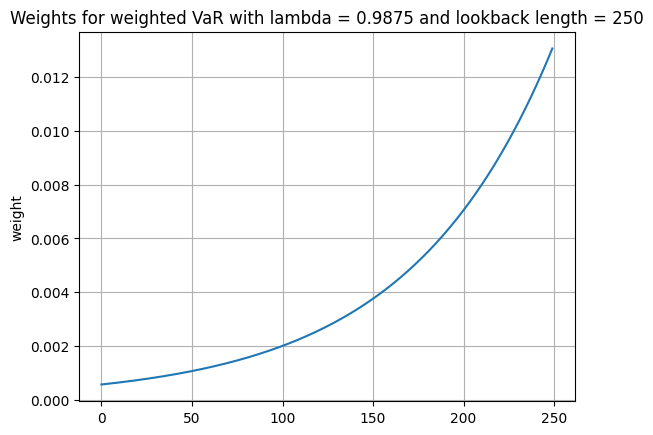

In [ ]:
lam = 0.9875
n = 250
weights = np.zeros(n)
for i in range(n):
  weights[i] = (1-lam)*(lam**i)/(1-lam**n)
weights = np.flip(weights) # reversed weights
plt.plot(weights)
plt.grid()
plt.title(f"Weights for weighted VaR with lambda = {lam} and lookback length = {n}")
plt.ylabel("weight")
plt.show()

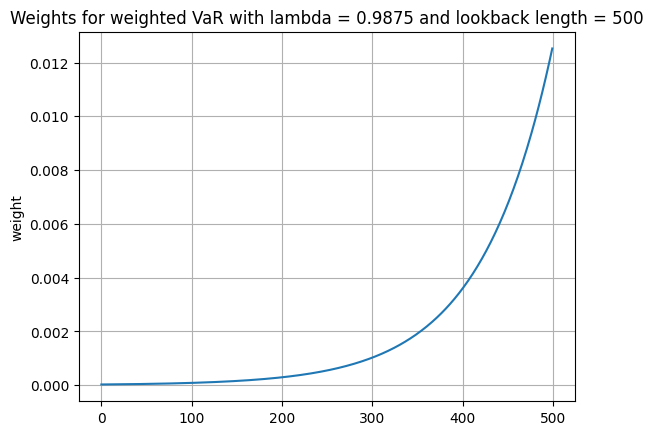

In [ ]:
lam = 0.9875
n = 500
weights = np.zeros(n)
for i in range(n):
  weights[i] = (1-lam)*(lam**i)/(1-lam**n)
weights = np.flip(weights) # reversed weights
plt.plot(weights)
plt.grid()
plt.title(f"Weights for weighted VaR with lambda = {lam} and lookback length = {n}")
plt.ylabel("weight")
plt.show()

# SP500

## Plots and tests

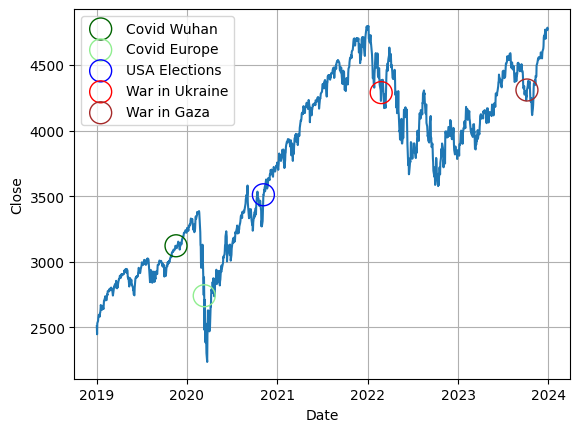

In [ ]:
SP500.Plot()

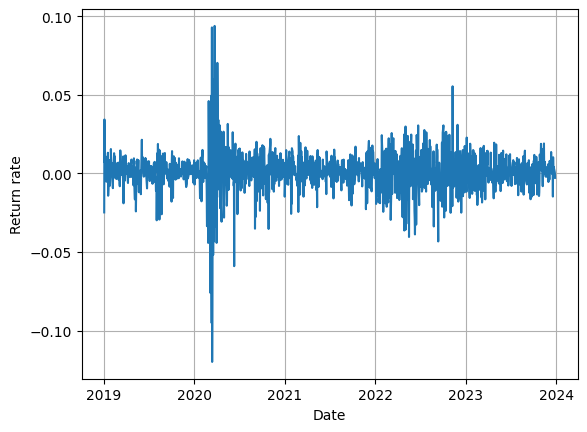

In [ ]:
SP500.RatesPlot()

In [ ]:
SP500.ShapiroWilk(0.99)
SP500.LjungBox()
SP500.Levene()
SP500.Adf()

P-value of Shapiro-Wilk test is: 1.2742861874495749e-30
Null hypothesis of normality is rejected at the 0.99 level of significance
Ljung-Box test:
       lb_stat     lb_pvalue
35  349.113606  1.963768e-53
Levene test: W-statistic=34.82812088161804, p-value=1.3196921214813751e-27
ADF test: ADF statistic=-10.611749333382114, p-value=5.809969843586665e-19
Critical value (1%): -3.4356006420838963
Critical value (5%): -2.8638586845641063
Critical value (10%): -2.5680044958343604


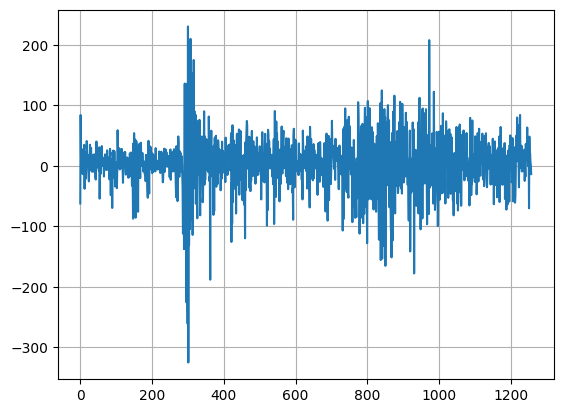

In [ ]:
plt.plot(SP500.PnL())
plt.grid()
plt.show()

## VaR estimation

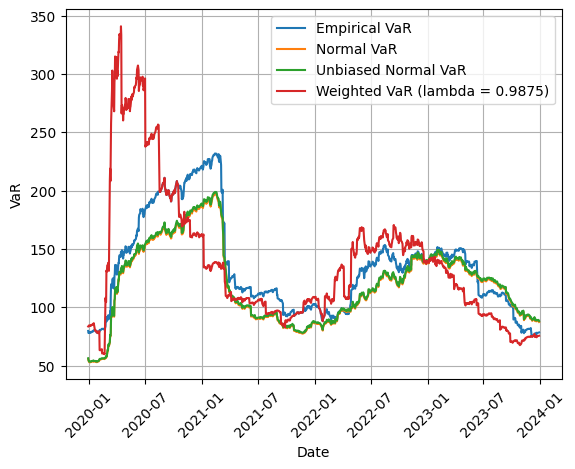

In [ ]:
figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(SP500.historicalData.index[250: -1], SP500.VarEmp(), label = 'Empirical VaR')
plt.plot(SP500.historicalData.index[250: -1], SP500.VarNorm(), label = 'Normal VaR')
plt.plot(SP500.historicalData.index[250: -1], SP500.VarUnbNorm(), label = 'Unbiased Normal VaR')
plt.plot(SP500.historicalData.index[250: -1], SP500.VarWeighted(lam = 0.9875), label = 'Weighted VaR (lambda = 0.9875)')
plt.xlabel("Date")
plt.ylabel("VaR")
plt.grid()
plt.legend()
plt.show()

##Backtesting

### lookback 250 days

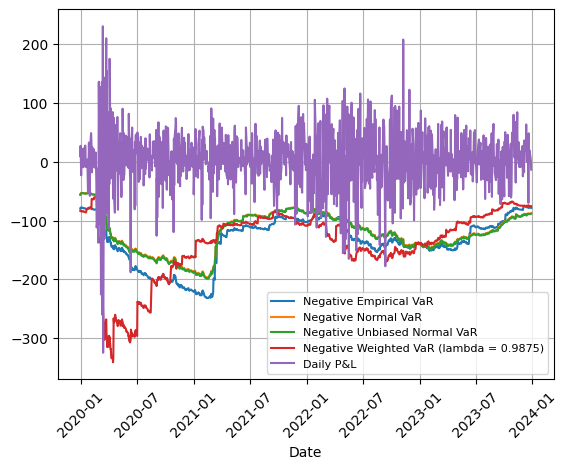

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(SP500.historicalData.index[250: -1], -SP500.VarEmp(), label = 'Negative Empirical VaR')
plt.plot(SP500.historicalData.index[250: -1], -SP500.VarNorm(), label = 'Negative Normal VaR')
plt.plot(SP500.historicalData.index[250: -1], -SP500.VarUnbNorm(), label = 'Negative Unbiased Normal VaR')
plt.plot(SP500.historicalData.index[250: -1], -SP500.VarWeighted(lam = lam), label = f'Negative Weighted VaR (lambda = {lam})')
plt.plot(SP500.historicalData.index[250: -1], SP500.PnL()[250:], label = 'Daily P&L')
plt.xlabel("Date")
plt.grid()
plt.legend(fontsize = "8")
plt.show()

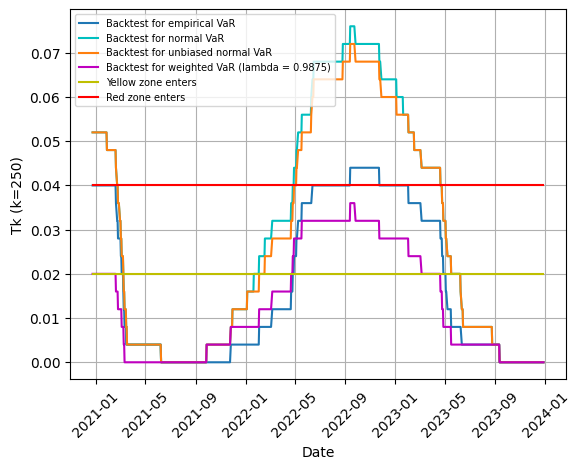

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(SP500.historicalData.index[500: -1], SP500.Backtest_daily(SP500.VarEmp()), label = 'Backtest for empirical VaR')
plt.plot(SP500.historicalData.index[500: -1], SP500.Backtest_daily(SP500.VarNorm()), label = 'Backtest for normal VaR', c = "c")
plt.plot(SP500.historicalData.index[500: -1], SP500.Backtest_daily(SP500.VarUnbNorm()), label = 'Backtest for unbiased normal VaR')
plt.plot(SP500.historicalData.index[500: -1], SP500.Backtest_daily(SP500.VarWeighted(lam = lam)), label = f'Backtest for weighted VaR (lambda = {lam})', c = "m")
plt.plot(SP500.historicalData.index[500: -1], np.full(len(SP500.Backtest_daily(SP500.VarEmp())), 0.02), label = 'Yellow zone enters', c = "y")
plt.plot(SP500.historicalData.index[500: -1], np.full(len(SP500.Backtest_daily(SP500.VarEmp())), 0.04), label = 'Red zone enters', c = "r")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Tk (k=250)")
plt.legend(fontsize = "7")
plt.show()

We can perform backtesting for all 1007 calculated VaRs. Then the green zone

In [ ]:
SP500.Backtest(SP500.VarEmp())
SP500.Backtest(SP500.VarNorm())
SP500.Backtest(SP500.VarUnbNorm())
SP500.Backtest(SP500.VarWeighted(0.9875))

Number of exceptions =  21
Yellow zone, watch out!
Number of exceptions =  32
Red zone, stay away!
Number of exceptions =  31
Red zone, stay away!
Number of exceptions =  14
Yellow zone, watch out!


### lookback 500 days

In [ ]:
SP5002 = StockData("^GSPC", 2019, 1, 1, 2024, 1, 1, lookback = 500)

[*********************100%%**********************]  1 of 1 completed


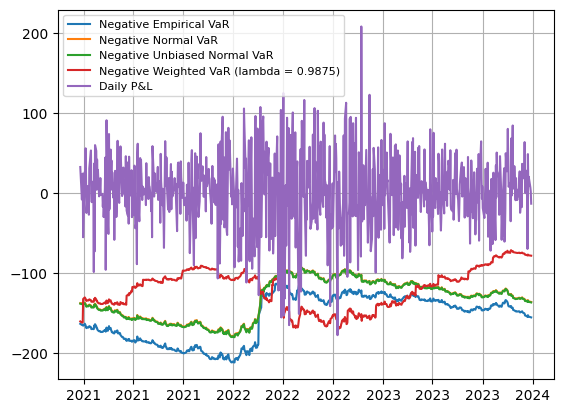

In [ ]:
lam = 0.9875
figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.plot(SP5002.historicalData.index[500: -1], -SP5002.VarEmp(), label = 'Negative Empirical VaR')
plt.plot(SP5002.historicalData.index[500: -1], -SP5002.VarNorm(), label = 'Negative Normal VaR')
plt.plot(SP5002.historicalData.index[500: -1], -SP5002.VarUnbNorm(), label = 'Negative Unbiased Normal VaR')
plt.plot(SP5002.historicalData.index[500: -1], -SP5002.VarWeighted(lam), label = f'Negative Weighted VaR (lambda = {lam})')
plt.plot(SP5002.historicalData.index[500: -1], SP5002.PnL()[500:], label = 'Daily P&L')
plt.grid()
plt.legend(fontsize = "8")
plt.show()

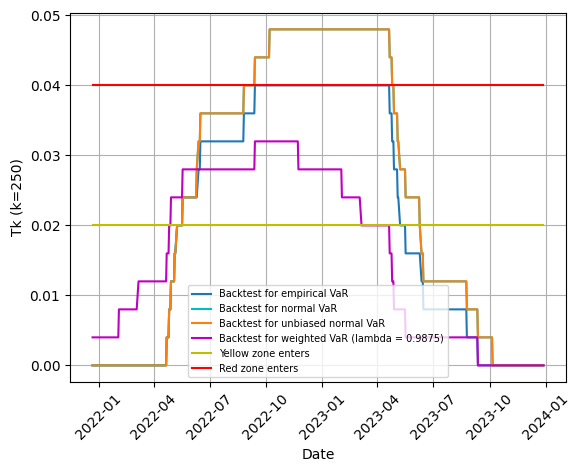

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(SP5002.historicalData.index[750: -1], SP5002.Backtest_daily(SP5002.VarEmp()), label = 'Backtest for empirical VaR')
plt.plot(SP5002.historicalData.index[750: -1], SP5002.Backtest_daily(SP5002.VarNorm()), label = 'Backtest for normal VaR', c = "c")
plt.plot(SP5002.historicalData.index[750: -1], SP5002.Backtest_daily(SP5002.VarUnbNorm()), label = 'Backtest for unbiased normal VaR')
plt.plot(SP5002.historicalData.index[750: -1], SP5002.Backtest_daily(SP5002.VarWeighted(lam = lam)), label = f'Backtest for weighted VaR (lambda = {lam})', c = "m")
plt.plot(SP5002.historicalData.index[750: -1], np.full(len(SP5002.Backtest_daily(SP5002.VarEmp())), 0.02), label = 'Yellow zone enters', c = "y")
plt.plot(SP5002.historicalData.index[750: -1], np.full(len(SP5002.Backtest_daily(SP5002.VarEmp())), 0.04), label = 'Red zone enters', c = "r")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Tk (k=250)")
plt.legend(fontsize = "7")
plt.show()

In [ ]:
SP5002.Backtest2(SP5002.VarEmp())
SP5002.Backtest2(SP5002.VarNorm())
SP5002.Backtest2(SP5002.VarUnbNorm())
SP5002.Backtest2(SP5002.VarWeighted(0.9875))

Number of exceptions =  10
Green zone, model looks to be correct
Number of exceptions =  12
Yellow zone, watch out!
Number of exceptions =  12
Yellow zone, watch out!
Number of exceptions =  8
Green zone, model looks to be correct


# DAX

## Plots and tests

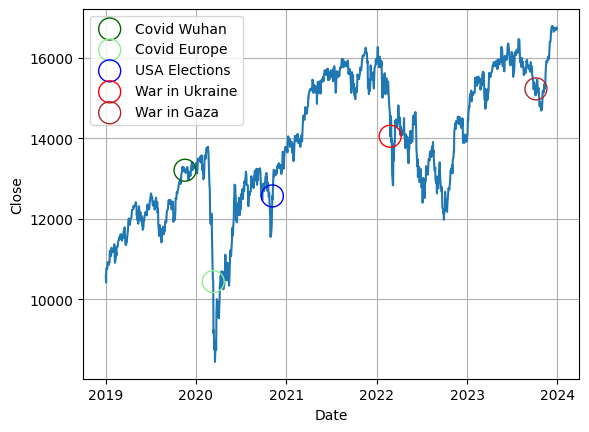

In [ ]:
DAX.Plot()

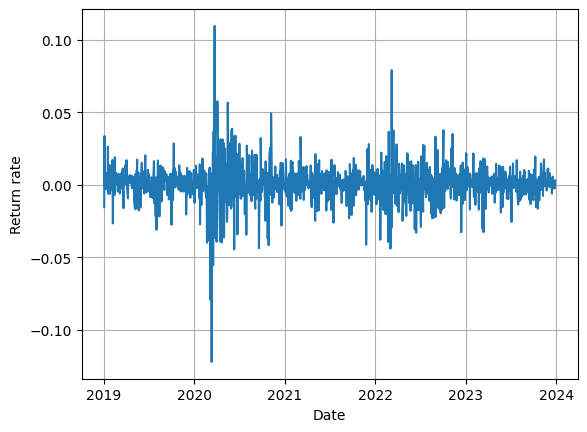

In [ ]:
DAX.RatesPlot()

In [ ]:
DAX.ShapiroWilk(0.99)
DAX.LjungBox()
DAX.Levene()
DAX.Adf()

P-value of Shapiro-Wilk test is: 2.536572815718498e-29
Null hypothesis of normality is rejected at the 0.99 level of significance
Ljung-Box test:
      lb_stat  lb_pvalue
35  83.940605   0.000007
Levene test: W-statistic=31.399302432112222, p-value=5.765874053468077e-25
ADF test: ADF statistic=-12.415471496731541, p-value=4.250277768437879e-23
Critical value (1%): -3.4355381554821585
Critical value (5%): -2.8638311143598556
Critical value (10%): -2.567989813198476


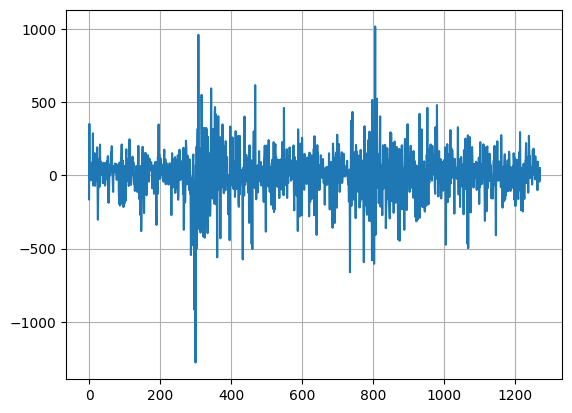

In [ ]:
plt.plot(DAX.PnL())
plt.grid()
plt.show()

## VaR estimation

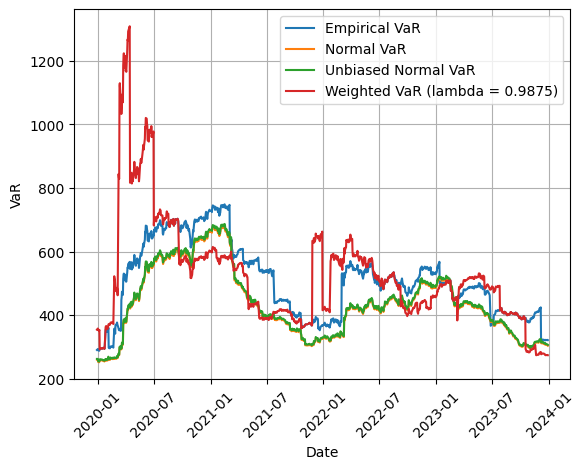

In [ ]:
figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(DAX.historicalData.index[250: -1], DAX.VarEmp(), label = 'Empirical VaR')
plt.plot(DAX.historicalData.index[250: -1], DAX.VarNorm(), label = 'Normal VaR')
plt.plot(DAX.historicalData.index[250: -1], DAX.VarUnbNorm(), label = 'Unbiased Normal VaR')
plt.plot(DAX.historicalData.index[250: -1], DAX.VarWeighted(lam = 0.9875), label = 'Weighted VaR (lambda = 0.9875)')
plt.xlabel("Date")
plt.ylabel("VaR")
plt.grid()
plt.legend()
plt.show()

## Backtesting

### Lookback 250 days

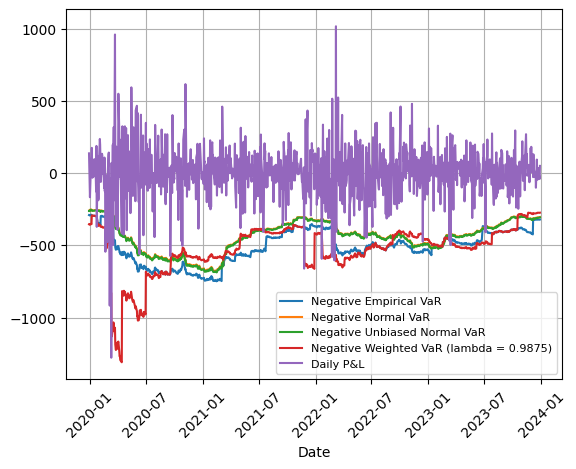

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(DAX.historicalData.index[250: -1], -DAX.VarEmp(), label = 'Negative Empirical VaR')
plt.plot(DAX.historicalData.index[250: -1], -DAX.VarNorm(), label = 'Negative Normal VaR')
plt.plot(DAX.historicalData.index[250: -1], -DAX.VarUnbNorm(), label = 'Negative Unbiased Normal VaR')
plt.plot(DAX.historicalData.index[250: -1], -DAX.VarWeighted(lam = lam), label = f'Negative Weighted VaR (lambda = {lam})')
plt.plot(DAX.historicalData.index[250: -1], DAX.PnL()[250:], label = 'Daily P&L')
plt.grid()
plt.xlabel("Date")
plt.legend(fontsize = "8")
plt.show()

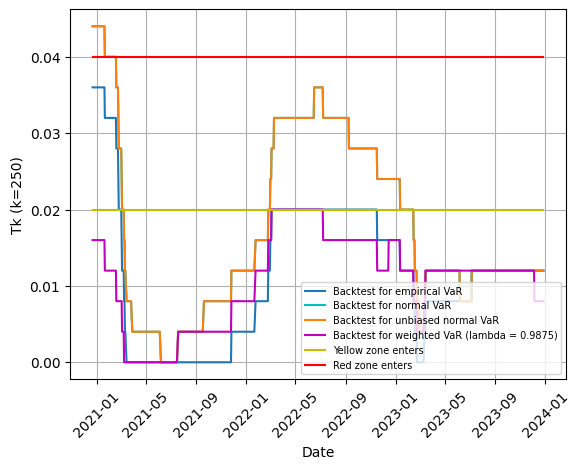

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(DAX.historicalData.index[500: -1], DAX.Backtest_daily(DAX.VarEmp()), label = 'Backtest for empirical VaR')
plt.plot(DAX.historicalData.index[500: -1], DAX.Backtest_daily(DAX.VarNorm()), label = 'Backtest for normal VaR', c = "c")
plt.plot(DAX.historicalData.index[500: -1], DAX.Backtest_daily(DAX.VarUnbNorm()), label = 'Backtest for unbiased normal VaR')
plt.plot(DAX.historicalData.index[500: -1], DAX.Backtest_daily(DAX.VarWeighted(lam = lam)), label = f'Backtest for weighted VaR (lambda = {lam})', c = "m")
plt.plot(DAX.historicalData.index[500: -1], np.full(len(DAX.Backtest_daily(DAX.VarEmp())), 0.02), label = 'Yellow zone enters', c = "y")
plt.plot(DAX.historicalData.index[500: -1], np.full(len(DAX.Backtest_daily(DAX.VarEmp())), 0.04), label = 'Red zone enters', c = "r")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Tk (k=250)")
plt.legend(fontsize = "7")
plt.show()

In [ ]:
DAX.Backtest(DAX.VarEmp())
DAX.Backtest(DAX.VarNorm())
DAX.Backtest(DAX.VarUnbNorm())
DAX.Backtest(DAX.VarWeighted(lam))

Number of exceptions =  17
Yellow zone, watch out!
Number of exceptions =  23
Yellow zone, watch out!
Number of exceptions =  23
Yellow zone, watch out!
Number of exceptions =  12
Green zone, model looks to be correct


### lookback 500 days

In [ ]:
DAX2 = StockData("^GDAXI", 2019, 1, 1, 2024, 1, 1, lookback = 500)

[*********************100%%**********************]  1 of 1 completed


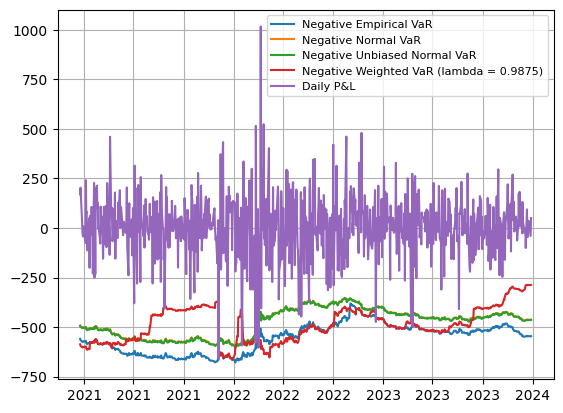

In [ ]:
lam = 0.9875
figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.plot(DAX2.historicalData.index[500: -1], -DAX2.VarEmp(), label = 'Negative Empirical VaR')
plt.plot(DAX2.historicalData.index[500: -1], -DAX2.VarNorm(), label = 'Negative Normal VaR')
plt.plot(DAX2.historicalData.index[500: -1], -DAX2.VarUnbNorm(), label = 'Negative Unbiased Normal VaR')
plt.plot(DAX2.historicalData.index[500: -1], -DAX2.VarWeighted(lam), label = f'Negative Weighted VaR (lambda = {lam})')
plt.plot(DAX2.historicalData.index[500: -1], DAX2.PnL()[500:], label = 'Daily P&L')
plt.grid()
plt.legend(fontsize = "8")
plt.show()

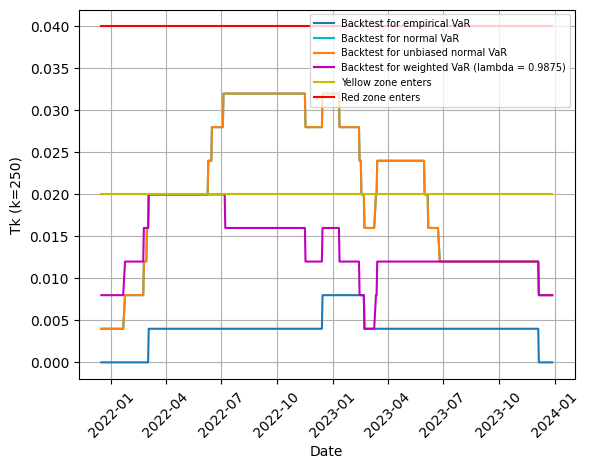

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(DAX2.historicalData.index[750: -1], DAX2.Backtest_daily(DAX2.VarEmp()), label = 'Backtest for empirical VaR')
plt.plot(DAX2.historicalData.index[750: -1], DAX2.Backtest_daily(DAX2.VarNorm()), label = 'Backtest for normal VaR', c = "c")
plt.plot(DAX2.historicalData.index[750: -1], DAX2.Backtest_daily(DAX2.VarUnbNorm()), label = 'Backtest for unbiased normal VaR')
plt.plot(DAX2.historicalData.index[750: -1], DAX2.Backtest_daily(DAX2.VarWeighted(lam = lam)), label = f'Backtest for weighted VaR (lambda = {lam})', c = "m")
plt.plot(DAX2.historicalData.index[750: -1], np.full(len(DAX2.Backtest_daily(DAX2.VarEmp())), 0.02), label = 'Yellow zone enters', c = "y")
plt.plot(DAX2.historicalData.index[750: -1], np.full(len(DAX2.Backtest_daily(DAX2.VarEmp())), 0.04), label = 'Red zone enters', c = "r")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Tk (k=250)")
plt.legend(fontsize = "7")
plt.show()

In [ ]:
DAX2.Backtest2(DAX2.VarEmp())
DAX2.Backtest2(DAX2.VarNorm())
DAX2.Backtest2(DAX2.VarUnbNorm())
DAX2.Backtest2(DAX2.VarWeighted(0.9875))

Number of exceptions =  2
Green zone, model looks to be correct
Number of exceptions =  11
Yellow zone, watch out!
Number of exceptions =  11
Yellow zone, watch out!
Number of exceptions =  8
Green zone, model looks to be correct


# FTSE

## Plots and tests

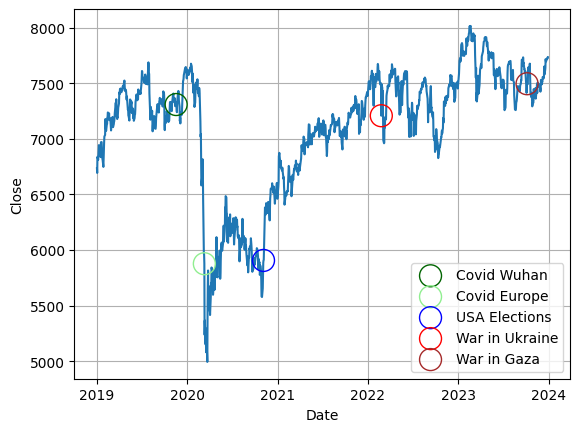

In [ ]:
FTSE.Plot()

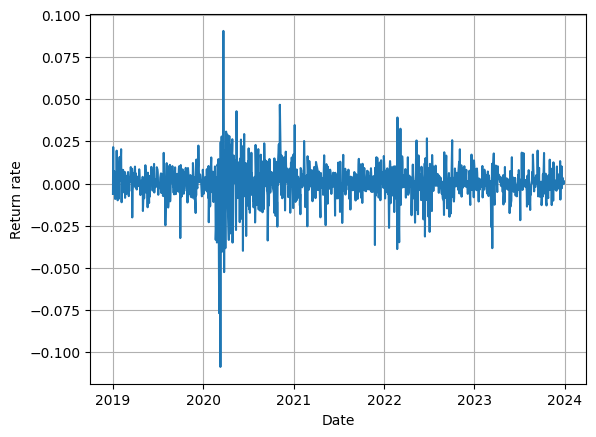

In [ ]:
FTSE.RatesPlot()

In [ ]:
FTSE.ShapiroWilk(0.99)
FTSE.LjungBox()
FTSE.Levene()
FTSE.Adf()

P-value of Shapiro-Wilk test is: 7.432682001379282e-30
Null hypothesis of normality is rejected at the 0.99 level of significance
Ljung-Box test:
       lb_stat     lb_pvalue
35  111.016776  7.782128e-10
Levene test: W-statistic=36.127483248359496, p-value=1.3134208763377329e-28
ADF test: ADF statistic=-8.031151312832353, p-value=1.956783084380826e-12
Critical value (1%): -3.4356431428057386
Critical value (5%): -2.8638774363142963
Critical value (10%): -2.568014482215048


## VaR estimation

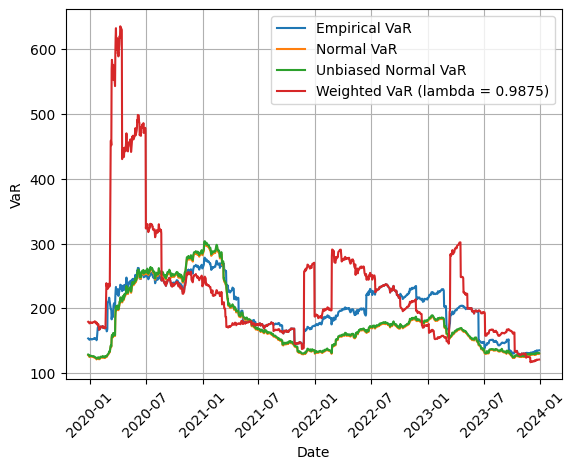

In [ ]:
figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(FTSE.historicalData.index[250: -1], FTSE.VarEmp(), label = 'Empirical VaR')
plt.plot(FTSE.historicalData.index[250: -1], FTSE.VarNorm(), label = 'Normal VaR')
plt.plot(FTSE.historicalData.index[250: -1], FTSE.VarUnbNorm(), label = 'Unbiased Normal VaR')
plt.plot(FTSE.historicalData.index[250: -1], FTSE.VarWeighted(lam = 0.9875), label = 'Weighted VaR (lambda = 0.9875)')
plt.xlabel("Date")
plt.ylabel("VaR")
plt.grid()
plt.legend()
plt.show()

##Backtesting

### lookback 250 days

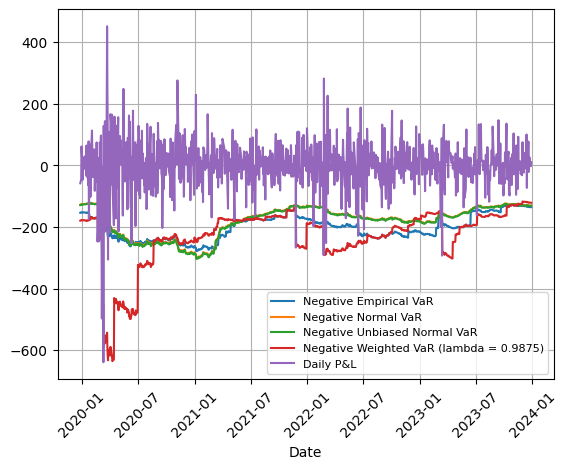

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(FTSE.historicalData.index[250: -1], -FTSE.VarEmp(), label = 'Negative Empirical VaR')
plt.plot(FTSE.historicalData.index[250: -1], -FTSE.VarNorm(), label = 'Negative Normal VaR')
plt.plot(FTSE.historicalData.index[250: -1], -FTSE.VarUnbNorm(), label = 'Negative Unbiased Normal VaR')
plt.plot(FTSE.historicalData.index[250: -1], -FTSE.VarWeighted(lam = lam), label = f'Negative Weighted VaR (lambda = {lam})')
plt.plot(FTSE.historicalData.index[250: -1], FTSE.PnL()[250:], label = 'Daily P&L')
plt.xlabel("Date")
plt.grid()
plt.legend(fontsize = "8")
plt.show()

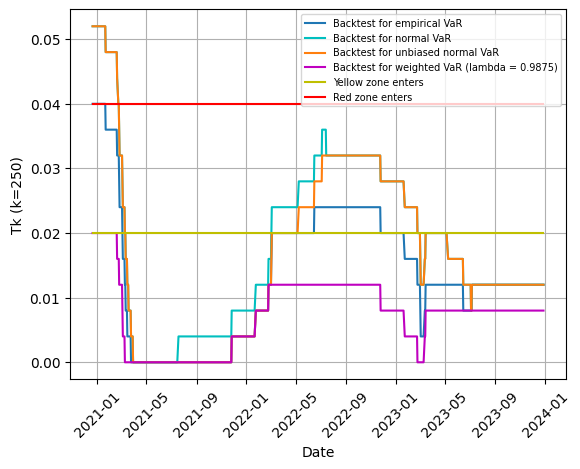

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(FTSE.historicalData.index[500: -1], FTSE.Backtest_daily(FTSE.VarEmp()), label = 'Backtest for empirical VaR')
plt.plot(FTSE.historicalData.index[500: -1], FTSE.Backtest_daily(FTSE.VarNorm()), label = 'Backtest for normal VaR', c = "c")
plt.plot(FTSE.historicalData.index[500: -1], FTSE.Backtest_daily(FTSE.VarUnbNorm()), label = 'Backtest for unbiased normal VaR')
plt.plot(FTSE.historicalData.index[500: -1], FTSE.Backtest_daily(FTSE.VarWeighted(lam = lam)), label = f'Backtest for weighted VaR (lambda = {lam})', c = "m")
plt.plot(FTSE.historicalData.index[500: -1], np.full(len(FTSE.Backtest_daily(FTSE.VarEmp())), 0.02), label = 'Yellow zone enters', c = "y")
plt.plot(FTSE.historicalData.index[500: -1], np.full(len(FTSE.Backtest_daily(FTSE.VarEmp())), 0.04), label = 'Red zone enters', c = "r")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Tk (k=250)")
plt.legend(fontsize = "7")
plt.show()

We can perform backtesting for all 1007 calculated VaRs. Then the green zone

In [ ]:
FTSE.Backtest(FTSE.VarEmp())
FTSE.Backtest(FTSE.VarNorm())
FTSE.Backtest(FTSE.VarUnbNorm())
FTSE.Backtest(FTSE.VarWeighted(0.9875))

Number of exceptions =  19
Yellow zone, watch out!
Number of exceptions =  25
Red zone, stay away!
Number of exceptions =  24
Red zone, stay away!
Number of exceptions =  10
Green zone, model looks to be correct


### lookback 500 days

In [ ]:
FTSE2 = StockData("^FTSE", 2019, 1, 1, 2024, 1, 1, lookback = 500)

[*********************100%%**********************]  1 of 1 completed


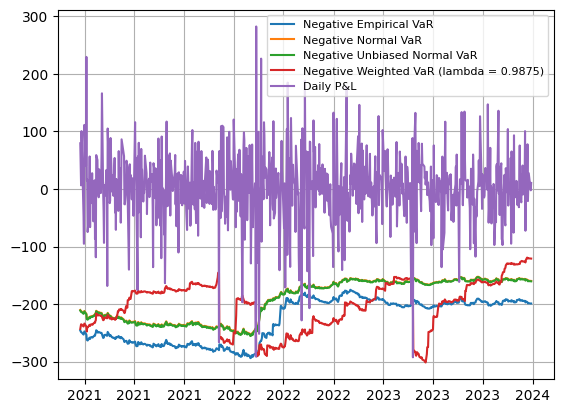

In [ ]:
lam = 0.9875
figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.plot(FTSE2.historicalData.index[500: -1], -FTSE2.VarEmp(), label = 'Negative Empirical VaR')
plt.plot(FTSE2.historicalData.index[500: -1], -FTSE2.VarNorm(), label = 'Negative Normal VaR')
plt.plot(FTSE2.historicalData.index[500: -1], -FTSE2.VarUnbNorm(), label = 'Negative Unbiased Normal VaR')
plt.plot(FTSE2.historicalData.index[500: -1], -FTSE2.VarWeighted(lam), label = f'Negative Weighted VaR (lambda = {lam})')
plt.plot(FTSE2.historicalData.index[500: -1], FTSE2.PnL()[500:], label = 'Daily P&L')
plt.grid()
plt.legend(fontsize = "8")
plt.show()

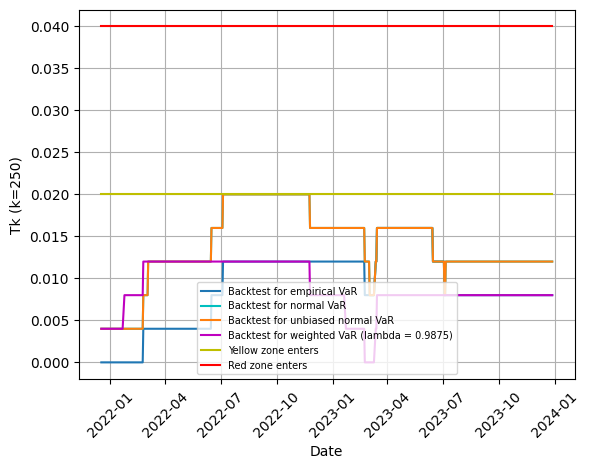

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(FTSE2.historicalData.index[750: -1], FTSE2.Backtest_daily(FTSE2.VarEmp()), label = 'Backtest for empirical VaR')
plt.plot(FTSE2.historicalData.index[750: -1], FTSE2.Backtest_daily(FTSE2.VarNorm()), label = 'Backtest for normal VaR', c = "c")
plt.plot(FTSE2.historicalData.index[750: -1], FTSE2.Backtest_daily(FTSE2.VarUnbNorm()), label = 'Backtest for unbiased normal VaR')
plt.plot(FTSE2.historicalData.index[750: -1], FTSE2.Backtest_daily(FTSE2.VarWeighted(lam = lam)), label = f'Backtest for weighted VaR (lambda = {lam})', c = "m")
plt.plot(FTSE2.historicalData.index[750: -1], np.full(len(FTSE2.Backtest_daily(FTSE2.VarEmp())), 0.02), label = 'Yellow zone enters', c = "y")
plt.plot(FTSE2.historicalData.index[750: -1], np.full(len(FTSE2.Backtest_daily(FTSE2.VarEmp())), 0.04), label = 'Red zone enters', c = "r")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Tk (k=250)")
plt.legend(fontsize = "7")
plt.show()

In [ ]:
FTSE2.Backtest2(FTSE2.VarEmp())
FTSE2.Backtest2(FTSE2.VarNorm())
FTSE2.Backtest2(FTSE2.VarUnbNorm())
FTSE2.Backtest2(FTSE2.VarWeighted(0.9875))

Number of exceptions =  5
Green zone, model looks to be correct
Number of exceptions =  8
Green zone, model looks to be correct
Number of exceptions =  8
Green zone, model looks to be correct
Number of exceptions =  5
Green zone, model looks to be correct


# NIKKEI

## Plots and tests

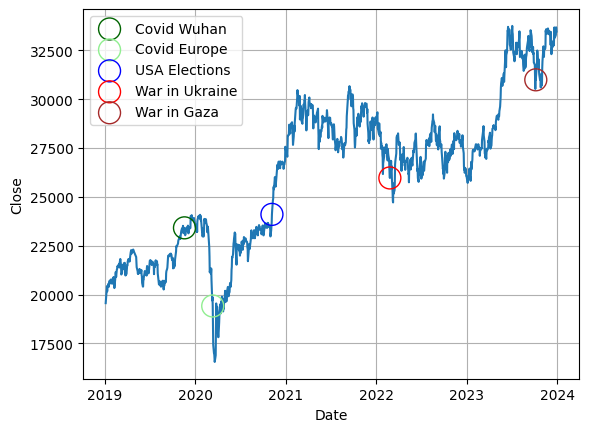

In [ ]:
NIKKEI.Plot()

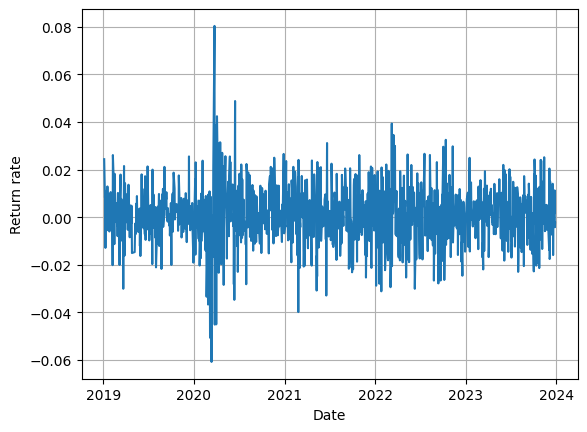

In [ ]:
NIKKEI.RatesPlot()

In [ ]:
NIKKEI.ShapiroWilk(0.99)
NIKKEI.LjungBox()
NIKKEI.Levene()
NIKKEI.Adf()

P-value of Shapiro-Wilk test is: 1.4234230918722091e-15
Null hypothesis of normality is rejected at the 0.99 level of significance
Ljung-Box test:
      lb_stat  lb_pvalue
34  43.077152   0.136757
Levene test: W-statistic=11.198327514885243, p-value=6.349891509572685e-09
ADF test: ADF statistic=-22.82636768832201, p-value=0.0
Critical value (1%): -3.435743555099632
Critical value (5%): -2.8639217381867486
Critical value (10%): -2.568038075665972


## VaR estimation

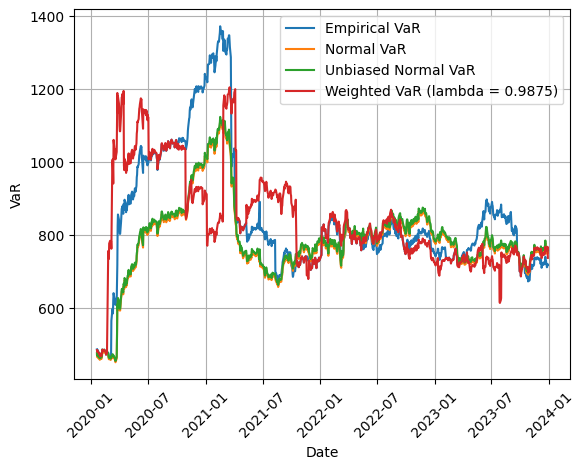

In [ ]:
figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(NIKKEI.historicalData.index[250: -1], NIKKEI.VarEmp(), label = 'Empirical VaR')
plt.plot(NIKKEI.historicalData.index[250: -1], NIKKEI.VarNorm(), label = 'Normal VaR')
plt.plot(NIKKEI.historicalData.index[250: -1], NIKKEI.VarUnbNorm(), label = 'Unbiased Normal VaR')
plt.plot(NIKKEI.historicalData.index[250: -1], NIKKEI.VarWeighted(lam = 0.9875), label = 'Weighted VaR (lambda = 0.9875)')
plt.xlabel("Date")
plt.ylabel("VaR")
plt.grid()
plt.legend()
plt.show()

##Backtesting

### lookback 250 days

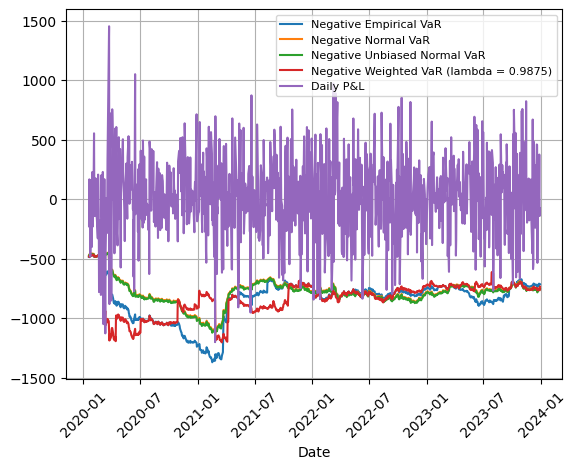

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(NIKKEI.historicalData.index[250: -1], -NIKKEI.VarEmp(), label = 'Negative Empirical VaR')
plt.plot(NIKKEI.historicalData.index[250: -1], -NIKKEI.VarNorm(), label = 'Negative Normal VaR')
plt.plot(NIKKEI.historicalData.index[250: -1], -NIKKEI.VarUnbNorm(), label = 'Negative Unbiased Normal VaR')
plt.plot(NIKKEI.historicalData.index[250: -1], -NIKKEI.VarWeighted(lam = lam), label = f'Negative Weighted VaR (lambda = {lam})')
plt.plot(NIKKEI.historicalData.index[250: -1], NIKKEI.PnL()[250:], label = 'Daily P&L')
plt.xlabel("Date")
plt.grid()
plt.legend(fontsize = "8")
plt.show()

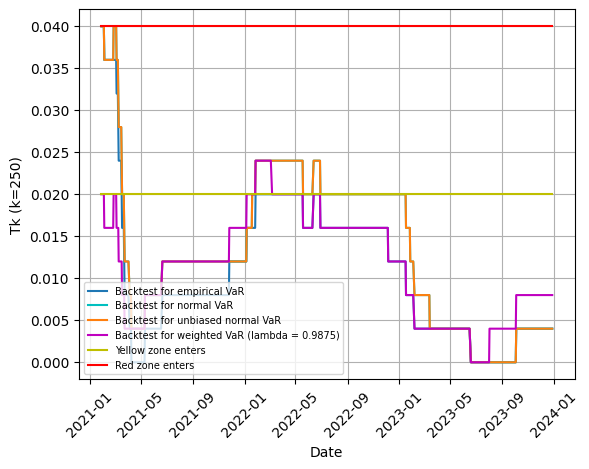

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(NIKKEI.historicalData.index[500: -1], NIKKEI.Backtest_daily(NIKKEI.VarEmp()), label = 'Backtest for empirical VaR')
plt.plot(NIKKEI.historicalData.index[500: -1], NIKKEI.Backtest_daily(NIKKEI.VarNorm()), label = 'Backtest for normal VaR', c = "c")
plt.plot(NIKKEI.historicalData.index[500: -1], NIKKEI.Backtest_daily(NIKKEI.VarUnbNorm()), label = 'Backtest for unbiased normal VaR')
plt.plot(NIKKEI.historicalData.index[500: -1], NIKKEI.Backtest_daily(NIKKEI.VarWeighted(lam = lam)), label = f'Backtest for weighted VaR (lambda = {lam})', c = "m")
plt.plot(NIKKEI.historicalData.index[500: -1], np.full(len(NIKKEI.Backtest_daily(NIKKEI.VarEmp())), 0.02), label = 'Yellow zone enters', c = "y")
plt.plot(NIKKEI.historicalData.index[500: -1], np.full(len(NIKKEI.Backtest_daily(NIKKEI.VarEmp())), 0.04), label = 'Red zone enters', c = "r")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Tk (k=250)")
plt.legend(fontsize = "7")
plt.show()

We can perform backtesting for all 1007 calculated VaRs. Then the green zone

In [ ]:
NIKKEI.Backtest(NIKKEI.VarEmp())
NIKKEI.Backtest(NIKKEI.VarNorm())
NIKKEI.Backtest(NIKKEI.VarUnbNorm())
NIKKEI.Backtest(NIKKEI.VarWeighted(0.9875))

Number of exceptions =  17
Yellow zone, watch out!
Number of exceptions =  19
Yellow zone, watch out!
Number of exceptions =  19
Yellow zone, watch out!
Number of exceptions =  14
Yellow zone, watch out!


### lookback 500 days

In [ ]:
NIKKEI2 = StockData("^N225", 2019, 1, 1, 2024, 1, 1, lookback = 500)

[*********************100%%**********************]  1 of 1 completed


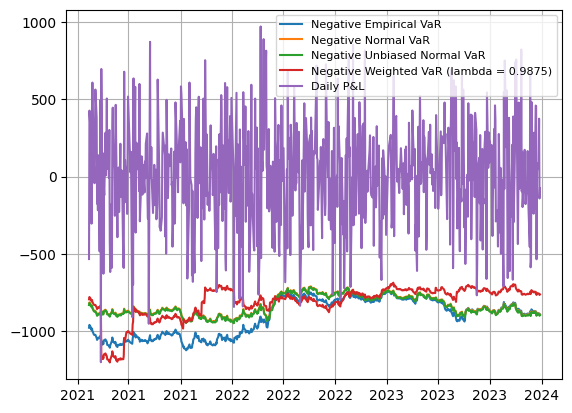

In [ ]:
lam = 0.9875
figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.plot(NIKKEI2.historicalData.index[500: -1], -NIKKEI2.VarEmp(), label = 'Negative Empirical VaR')
plt.plot(NIKKEI2.historicalData.index[500: -1], -NIKKEI2.VarNorm(), label = 'Negative Normal VaR')
plt.plot(NIKKEI2.historicalData.index[500: -1], -NIKKEI2.VarUnbNorm(), label = 'Negative Unbiased Normal VaR')
plt.plot(NIKKEI2.historicalData.index[500: -1], -NIKKEI2.VarWeighted(lam), label = f'Negative Weighted VaR (lambda = {lam})')
plt.plot(NIKKEI2.historicalData.index[500: -1], NIKKEI2.PnL()[500:], label = 'Daily P&L')
plt.grid()
plt.legend(fontsize = "8")
plt.show()

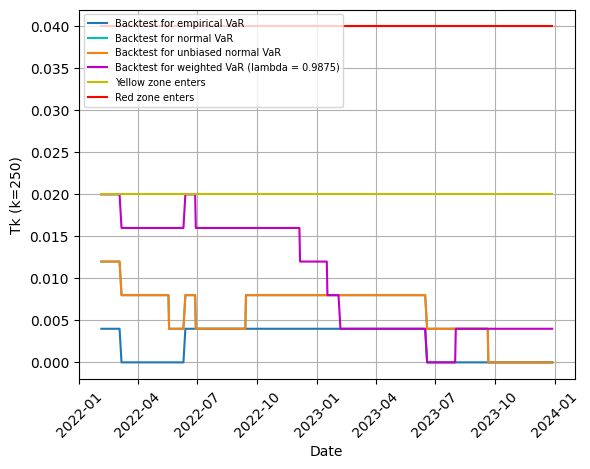

In [ ]:
lam = 0.9875

figure, axes = plt.subplots()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(NIKKEI2.historicalData.index[750: -1], NIKKEI2.Backtest_daily(NIKKEI2.VarEmp()), label = 'Backtest for empirical VaR')
plt.plot(NIKKEI2.historicalData.index[750: -1], NIKKEI2.Backtest_daily(NIKKEI2.VarNorm()), label = 'Backtest for normal VaR', c = "c")
plt.plot(NIKKEI2.historicalData.index[750: -1], NIKKEI2.Backtest_daily(NIKKEI2.VarUnbNorm()), label = 'Backtest for unbiased normal VaR')
plt.plot(NIKKEI2.historicalData.index[750: -1], NIKKEI2.Backtest_daily(NIKKEI2.VarWeighted(lam = lam)), label = f'Backtest for weighted VaR (lambda = {lam})', c = "m")
plt.plot(NIKKEI2.historicalData.index[750: -1], np.full(len(NIKKEI2.Backtest_daily(NIKKEI2.VarEmp())), 0.02), label = 'Yellow zone enters', c = "y")
plt.plot(NIKKEI2.historicalData.index[750: -1], np.full(len(NIKKEI2.Backtest_daily(NIKKEI2.VarEmp())), 0.04), label = 'Red zone enters', c = "r")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Tk (k=250)")
plt.legend(fontsize = "7")
plt.show()

In [ ]:
NIKKEI2.Backtest2(NIKKEI2.VarEmp())
NIKKEI2.Backtest2(NIKKEI2.VarNorm())
NIKKEI2.Backtest2(NIKKEI2.VarUnbNorm())
NIKKEI2.Backtest2(NIKKEI2.VarWeighted(0.9875))

Number of exceptions =  2
Green zone, model looks to be correct
Number of exceptions =  5
Green zone, model looks to be correct
Number of exceptions =  5
Green zone, model looks to be correct
Number of exceptions =  7
Green zone, model looks to be correct
